##          Palmer Penguins Data Analysis and Prediction
This project demonstrates my ability to work through the entire data science pipeline—from data preprocessing to modeling—while communicating insights clearly. It’s a great example of my skills in Python, pandas, seaborn, scikit-learn, and critical thinking, making it a strong addition to my portfolio.

### Introduction
This project analyzes the Palmer Penguins dataset, which contains measurements of penguins from three species in the Palmer Archipelago, Antarctica. The dataset includes features like bill length, bill depth, flipper length, body mass, species, island, and sex. The goal is to:

    * Clean and preprocess the data.
    * Explore relationships between features.
    * Build a simple machine learning model to predict penguin body mass.
This project demonstrates key data science skills: data cleaning, exploratory data analysis (EDA), preprocessing, and modeling.

In [6]:
# Import libraries for data manipulation, visualization, and modeling
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy import stats
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

# Set plot style for better visuals
sns.set_style("whitegrid")

### Data Loading and Initial Exploration
I load the Palmer Penguins dataset and check its structure to understand what I'm working with.

In [7]:
# Load the dataset
penguins = sns.load_dataset('penguins')
df = pd.DataFrame(penguins)

# Display the first 5 rows
print("First 5 rows of the dataset:")
display(df.head())

# Display basic information
print("\nDataset Info:")
df.info()

# Display summary statistics
print("\nSummary Statistics:")
display(df.describe())

First 5 rows of the dataset:


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB

Summary Statistics:


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


## Data Cleaning

I clean the data by filling missing values and removing outliers to make it ready for analysis.

In [8]:
# Separate numerical and categorical columns
df_numeric = df.select_dtypes(include=np.number)
df_cat = df.select_dtypes(exclude=np.number)

# Fill missing numerical values with species-specific median
for col in df_numeric.columns:
    df_numeric[col] = df.groupby('species')[col].transform(lambda x: x.fillna(x.median()))


# Fill missing categorical values with mode
for col in df_cat.columns:
    df_cat[col].fillna(df_cat[col].mode()[0], inplace=True)

# Combine cleaned numerical and categorical data
df_clean = pd.concat([df_numeric, df_cat], axis=1)

# Verify no missing values remain
print("Missing Values After Cleaning:")
print(df_clean.isna().sum())

# Remove outliers based on Z-score
df_numeric = df_numeric[(np.abs(stats.zscore(df_numeric)) < 2).all(axis=1)]

# Recombine with categorical data and drop rows with missing values
df_clean = pd.concat([df_numeric, df_cat], axis=1)
df_clean.dropna(inplace=True)

# Check final dataset size
print(f"Dataset shape after outlier removal: {df_clean.shape}")


Missing Values After Cleaning:
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
species              0
island               0
sex                  0
dtype: int64
Dataset shape after outlier removal: (315, 7)


## Exploratory Data Analysis (EDA)
I plot the body mass distribution to see how it looks.

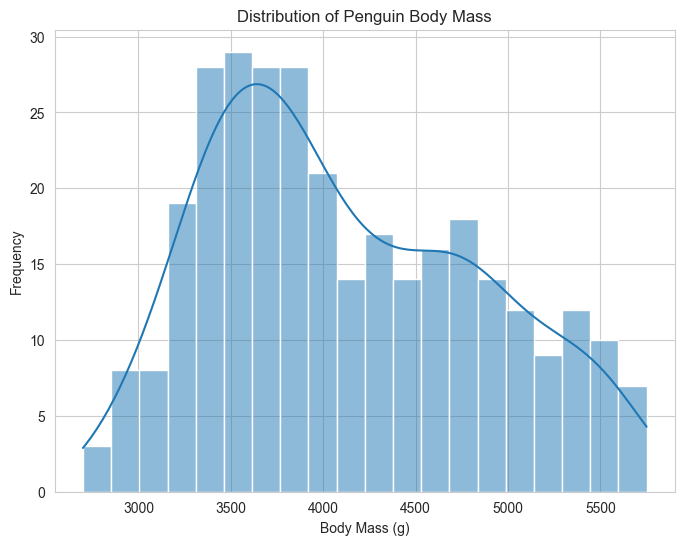

In [9]:
plt.figure(figsize=(8, 6))
sns.histplot(df_clean['body_mass_g'], bins=20, kde=True)
plt.title('Distribution of Penguin Body Mass')
plt.xlabel('Body Mass (g)')
plt.ylabel('Frequency')
plt.show()

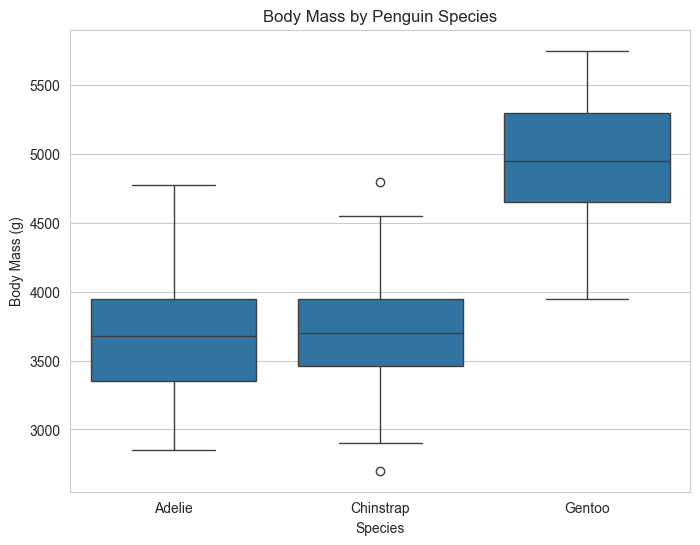

In [10]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='species', y='body_mass_g', data=df_clean)
plt.title('Body Mass by Penguin Species')
plt.xlabel('Species')
plt.ylabel('Body Mass (g)')
plt.show()

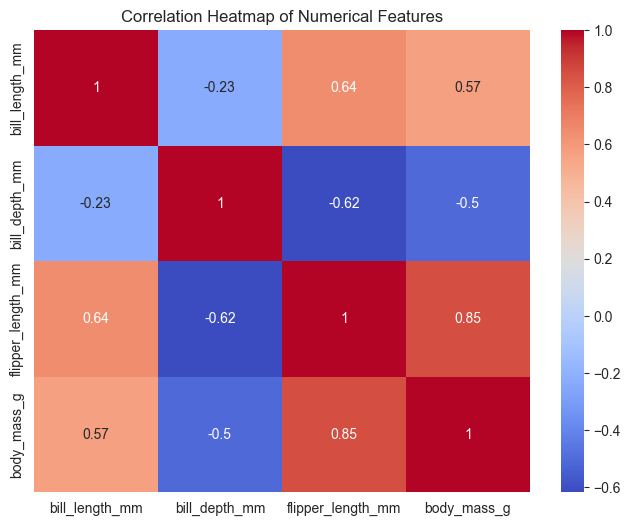

In [11]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_clean.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

## Preprocessing
I encode categorical variables, scale numerical features, and split the data for modeling.

In [12]:
# Define features and target
X = df_clean.drop('body_mass_g', axis=1)  # Features
y = df_clean['body_mass_g']  # Target

# Encode categorical variables
cat_columns = ['species', 'island', 'sex']
encoder = OneHotEncoder(sparse_output=False, drop='first')
X_encoded = pd.DataFrame(encoder.fit_transform(X[cat_columns]), 
                         columns=encoder.get_feature_names_out(cat_columns), 
                         index=X.index)

# Combine encoded categorical and numerical features
num_columns = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm']
X_combined = pd.concat([X[num_columns], X_encoded], axis=1)

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Modeling
I train a Linear Regression model to predict body mass based on the features.

In [13]:
# Initialize and train the model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Make predictions
y_pred = lr.predict(X_test)

## Evaluation
I calculate RMSE, MAE, and R² to check how well my model performs.

In [14]:
# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, lr.predict(X_train)))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
train_mae = mean_absolute_error(y_train, lr.predict(X_train))
test_mae = mean_absolute_error(y_test, y_pred)
r2_train = r2_score(y_train, lr.predict(X_train))
r2_test = r2_score(y_test, y_pred)

# Print results
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Train MAE: {train_mae:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Train R²: {r2_train:.2f}")
print(f"Test R²: {r2_test:.2f}")

Train RMSE: 279.72
Test RMSE: 304.57
Train MAE: 221.20
Test MAE: 248.55
Train R²: 0.85
Test R²: 0.82


## Conclusion
I cleaned the dataset, explored its features, and built a model to predict penguin body mass. I learned a lot about data preprocessing and modeling, but I think I can improve the model by trying Random Forest or getting more data.